In [1]:
import os, sys
import h5py

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import iqr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
%matplotlib inline

from matplotlib.colors import LogNorm, SymLogNorm
plt.rcParams['image.cmap'] = 'terrain_r'

import geom

sys.path.append('..')
from sprmodel import SprFitSet

In [2]:
basedir = "../data"
geom_fname = os.path.join(basedir, "agipd_taw9_oy2_1050addu_hmg5.geom")
geom_xy = geom.pixel_maps_from_geometry_file(geom_fname)

modules = (3, 4, 14, 15)

eV = 1.6021766208e-19
hc = 6.6260700400E-34 * 299792458

L = 5.465
lx = 200e-6
ly = 200e-6
Eph = 9200


lmd = hc / Eph / eV
lmd *= 1e10
lmd2 = lmd*lmd


In [3]:
CsI = type("CsI", (), {"rho": 4.51, "Mr": 259.809, "Ne": 108, "f": 108.})
IrCl3 = type("IrCl3", (), {"rho": 5.3, "Mr": 298.58, "Ne": 128, "f": 123.6})
HOH = type("HOH", (), {"rho": 1, "Mr": 18.01, "Ne": 10, "f": 10.04})
n = 1
IrCl3nW = type("IrCl3", (), {"rho": IrCl3.rho, 
                             "Mr": IrCl3.Mr + n*HOH.Mr, 
                             "Ne": IrCl3.Ne + n*HOH.Ne,
                             "f": IrCl3.f + n*HOH.f})

asf_k = .6022140857

asf = lambda M: M.rho * asf_k * M.f / M.Mr

print("Atomic scattering factor:")
print("CsI: {} IrCl3: {} IrCl3.{}(H20): {}".format(asf(CsI), asf(IrCl3), n, asf(IrCl3nW)))
print((asf(IrCl3nW)/asf(CsI)))


Atomic scattering factor:
CsI: 1.1290079899570684 IrCl3: 1.3212485875154263 IrCl3.1(H20): 1.347305408220804
1.193353297944363


In [4]:
# runs

grp_list = (
    (0, list(range(171, 182))),
    (0, list(range(184, 188))),
    (0, list(range(301, 314))),
    (0, list(range(314, 318))),
    #(1, [328, 329, 332, 339]),
    #(1, list(range(354, 359)))
)

run = type("run", (), {"i": [], "g": [], "s": []})
for i in range(len(grp_list)):
    j, r = grp_list[i]
    nr = len(r)
    run.i += r
    run.g += [i] * nr
    run.s += [j] * nr
    
asfs = [asf(IrCl3nW), asf(IrCl3nW)]



fits = SprFitSet([lx, ly], L, 6)
fits.read(run, asfs, os.path.join(basedir, "fits/fit_spr_r{:04d}.h5"), 1.09)


 run file                             Nfit   Nhit Rf/h,% Ncell      Imx
0171 ../data/fits/fit_spr_r0171.h5     458   3014   15.2    30    22.32
0172 ../data/fits/fit_spr_r0172.h5     395   2494   15.8    30    25.39
0173 ../data/fits/fit_spr_r0173.h5     560   3413   16.4    30    28.32
0174 ../data/fits/fit_spr_r0174.h5     588   3636   16.2    30    24.79
0175 ../data/fits/fit_spr_r0175.h5     727   4496   16.2    30    27.86
0176 ../data/fits/fit_spr_r0176.h5     572   2958   19.3    30    43.26
0177 ../data/fits/fit_spr_r0177.h5     645   3866   16.7    30    26.15
0178 ../data/fits/fit_spr_r0178.h5     530   3002   17.7    30    25.87
0179 ../data/fits/fit_spr_r0179.h5     745   4452   16.7    30    25.05
0180 ../data/fits/fit_spr_r0180.h5     723   4081   17.7    30    27.71
0181 ../data/fits/fit_spr_r0181.h5     634   3870   16.4    30   140.15
0184 ../data/fits/fit_spr_r0184.h5    1354   8479   16.0    30    30.34
0185 ../data/fits/fit_spr_r0185.h5    1639  10073   16.3    30  

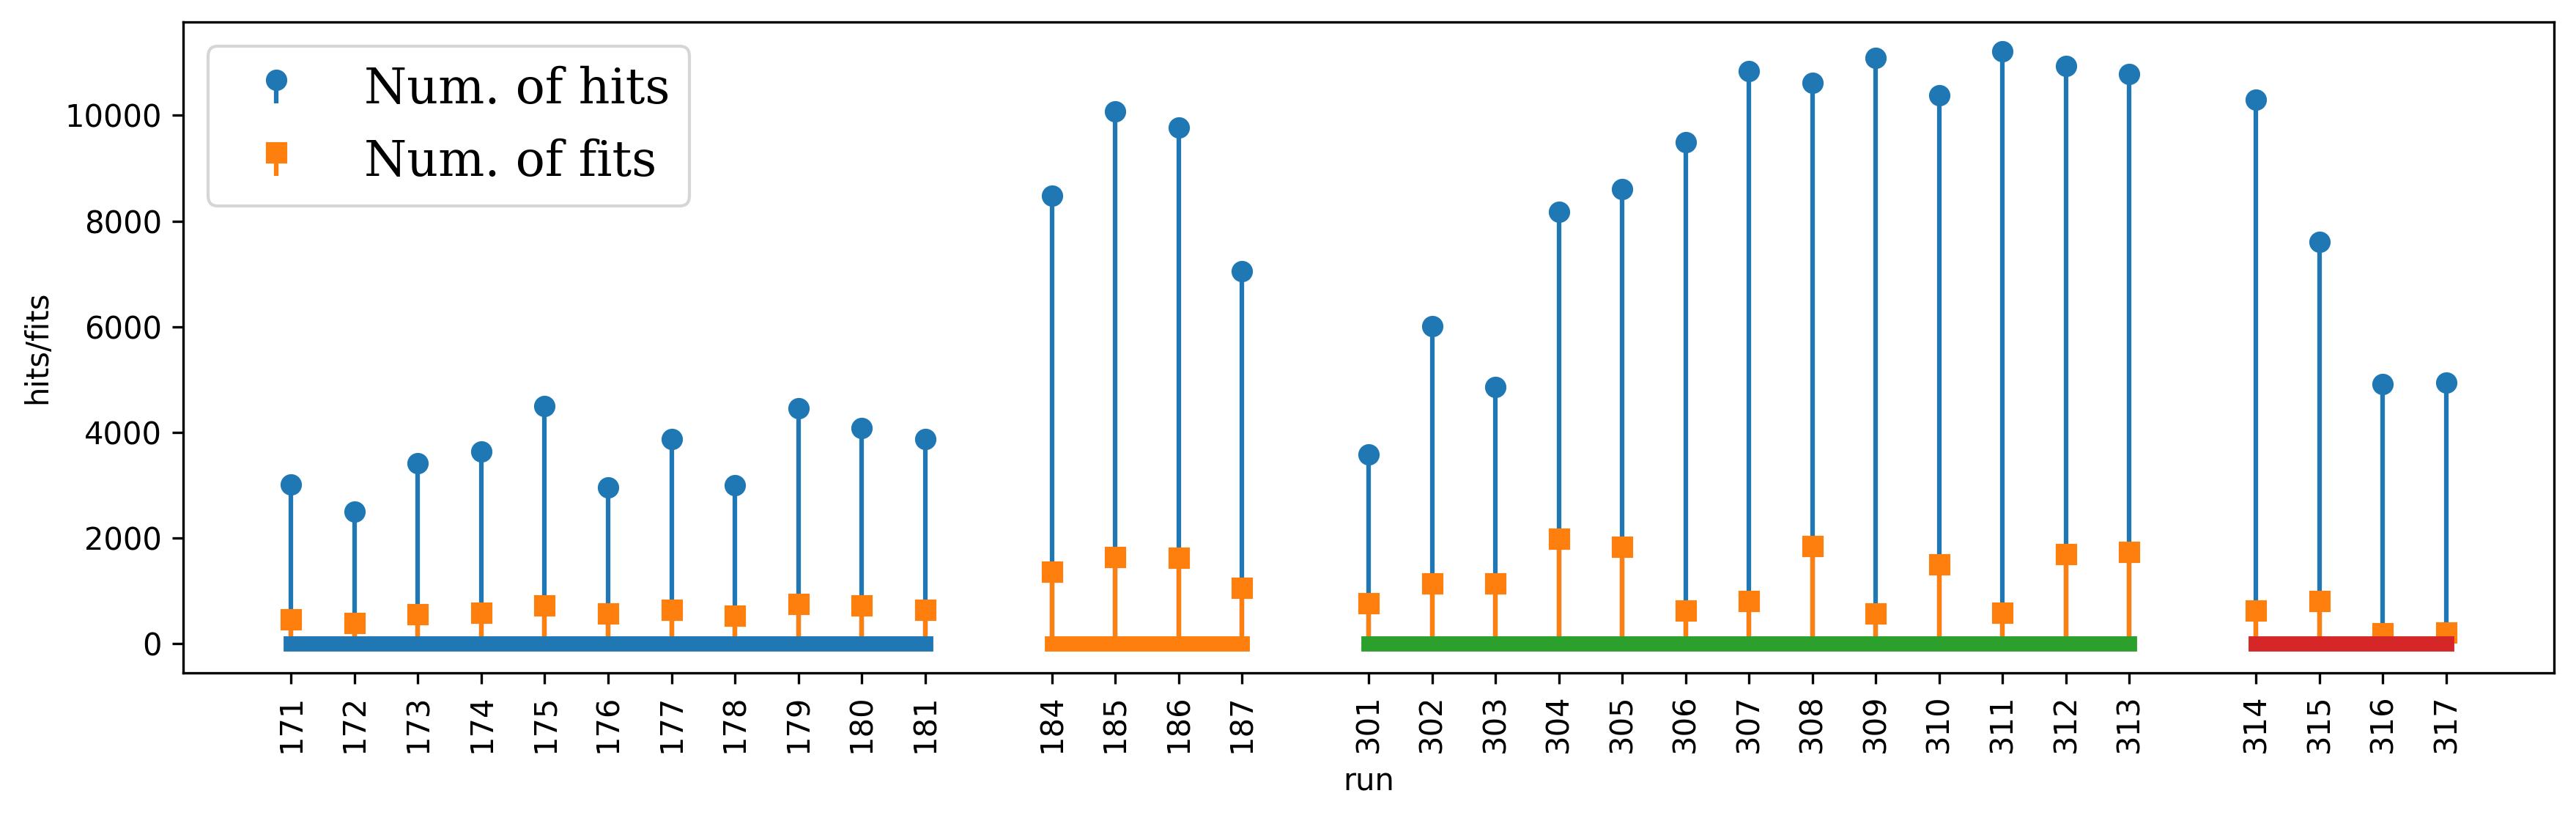

In [5]:
fig = plt.figure(figsize=(12, 4), tight_layout=True, dpi=300)
ax = fig.gca()
fits.plot_n_by_run((fits.nhit, fits.nfit), ("Num. of hits", "Num. of fits"), ax=ax)
ax.set_ylabel("hits/fits")
#ax.legend(("Num. of hits", "Num. of fits"), loc=2)
ax.legend()
plt.show()

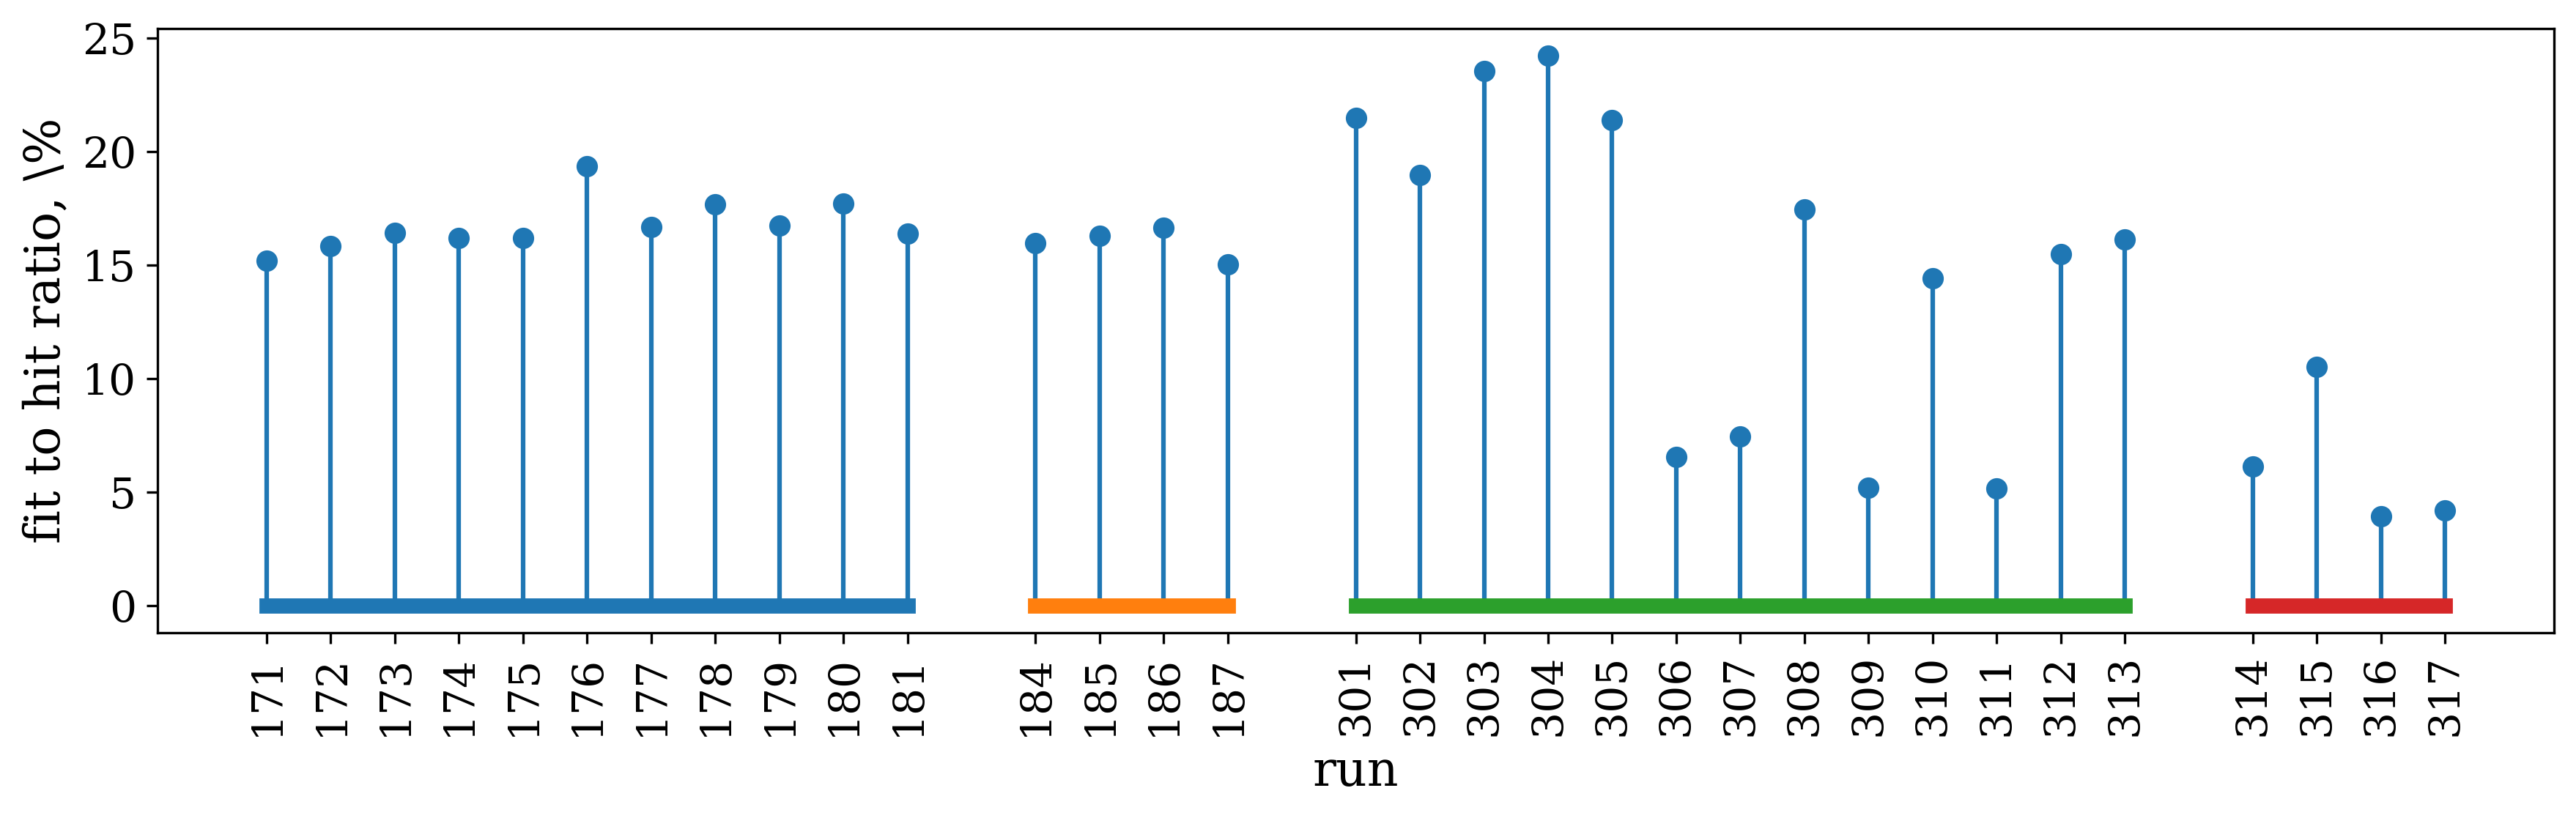

In [6]:
r = 100*np.array(fits.nfit, dtype=float) / np.array(fits.nhit, dtype=float)

fig = plt.figure(figsize=(12, 4), tight_layout=True, dpi=300)
ax = fig.gca()
fits.plot_n_by_run((r,), ax=ax)
ax.set_ylabel("fit to hit ratio, \%")
plt.show()

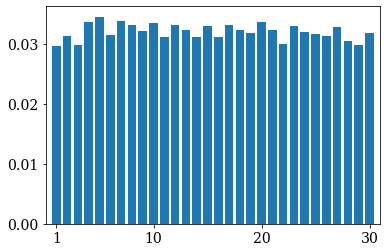

In [7]:
k, = np.where(fits.run < len(fits.runs)-3)

plt.bar(np.arange(1,31),np.bincount(fits.cell[k]) / float(fits.cell.size))
plt.xticks([1,10,20,30])
plt.xlim([0,31])
plt.show()


In [8]:
print(fits.cell.min(),fits.cell.max())

0 29


In [9]:
isize, = np.where(np.abs(fits.P[:,3]-4500)<1000)
fiti = isize[np.argmax(fits.P[isize,2])]
#print(dir(fits))
print(fits.run[fiti], fits.hit[fiti], fits.frm[fiti],  fits.P[fiti,2], fits.P[fiti,3], fits.train[fiti])
print(fits.P.shape)

2 147 1554 22.98556816895164 3500.6627273422105 51
(30306, 6)


In [10]:
fits.P[:,3] /= 10.

In [11]:
#fits.P[:,2] *= Eph*1e20*1.602176565e-19*1000
fits.P[:,2] *= 1e8

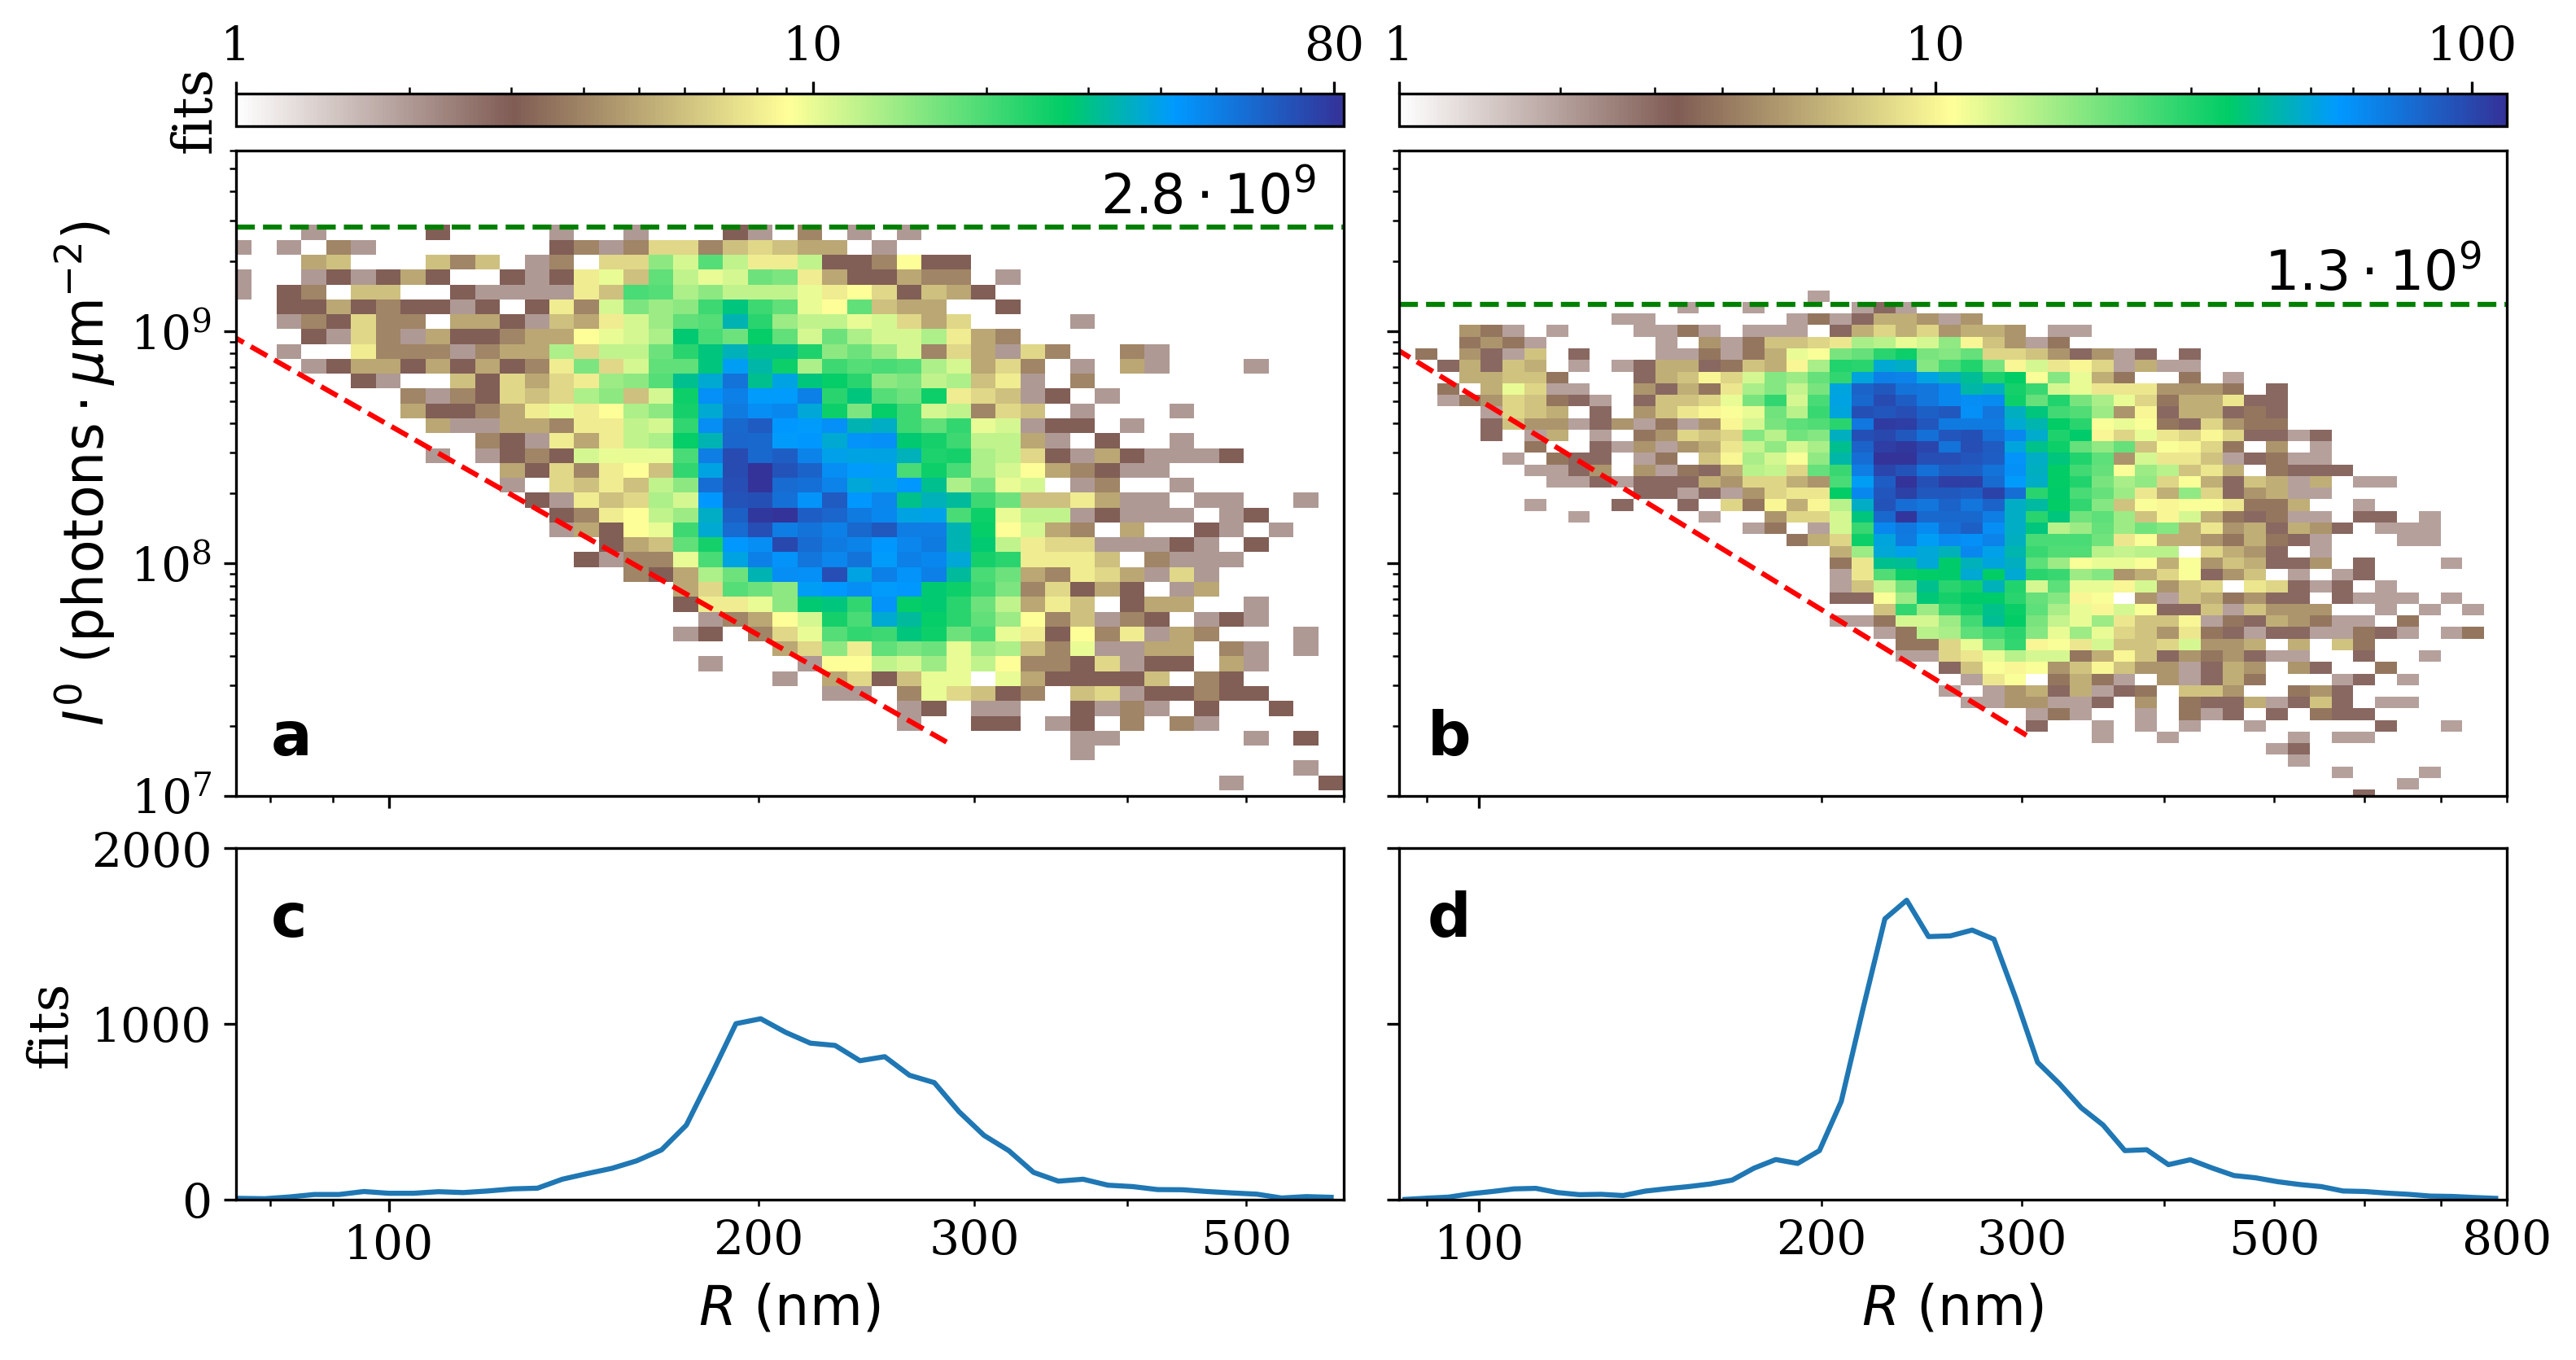

In [12]:
fig = plt.figure(figsize=(12, 6), tight_layout=False, dpi=300)
grid = plt.GridSpec(2, 2, hspace=0.1, wspace=0.05, height_ratios=[2, 1])

# 3rd shift
k, = np.where(fits.grp < 2)

ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])




divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("top", size="5%", pad=0.1)

H, Rb, Ib = fits.get_IR_distribution(k=k, Imx=60e8,Rmx=600)
hh = np.histogram(fits.P[k,3], bins=Rb)[0]
im = fits.plot_IR_distribution(Rb, Ib, H, ax=ax1)
cbar1 = plt.colorbar(im, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position('top')
#cax1.set_xticklabels([1, '', '', '', '', '', '', '', '', 10, '', '', '', '', '', '', 80])
cbar1.set_ticks([1,10,80])
cbar1.set_ticklabels([1,10,80])


#ax1.loglog(Rb[:30], 4e14 / Rb[:30]**3, 'r--')
ax1.loglog(Rb[:30], 2.8e9 * 52**3 / Rb[:30]**3, 'r--')

ax1.loglog([75, 600], [2.8e9, 2.8e9], 'g--')
ax1.text(380,3.2e9, '$2.8\cdot 10^9$', fontsize=16)
#ax1.text(80,2.5e8, '$4\cdot 10^{14}\cdot R^{-3}$', rotation=-30)


ax1.tick_params(which='both', labelbottom=False)
ax1.set_xlabel('')
ax1.set_xlim(75,600)
ax1.set_ylim(1e7,60e8)
ax1.set_ylabel('$I^0\ (\mathrm{photons}\cdot\mu\mathrm{m}^{-2})$')


ax2.plot(0.5*(Rb[1:]+Rb[:-1]),hh)
ax2.semilogx()
ax2.set_xlabel('$R\ (\mathrm{nm})$')
ax2.set_ylabel('fits')
ax2.set_ylim(0, 2000)
ax2.set_xlim(75,600)
ax2.set_xticks([100])
ax2.set_xticks([80, 90] + list(range(200, 600, 100)), minor=True)
ax2.set_xticklabels(['100'])
ax2.set_xticklabels(['', '', '200', '300', '','500', '', '', '800'], minor=True)

ax1.text(80,1.5e7,'$\mathbf{a}$', fontsize=18)
ax2.text(80,1500,'$\mathbf{c}$', fontsize=18)



# 4th shift
k, = np.where(np.logical_and(fits.grp >= 2, fits.grp < 4))

ax3 = fig.add_subplot(grid[0, 1])
ax4 = fig.add_subplot(grid[1, 1])

divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("top", size="5%", pad=0.1)

H, Rb, Ib = fits.get_IR_distribution(k=k, Imx=30e8,Rmx=800)
hh = np.histogram(fits.P[k,3], bins=Rb)[0]
H1 = H/hh
R1 = Rb
I1 = Ib
im = fits.plot_IR_distribution(Rb, Ib, H, ax=ax3)
cbar2 = plt.colorbar(im, cax=cax3, orientation='horizontal')
cax3.xaxis.set_ticks_position('top')
cbar2.set_ticks([1,10,100])
cbar2.set_ticklabels([1,10,100])
cax1.set_ylabel('fits')

#ax3.loglog(Rb[:30], 5e14 / Rb[:30]**3, 'r--')
ax3.loglog(Rb[:30], 1.3e9 * 73**3 / Rb[:30]**3, 'r--')
ax3.loglog([85, 800], [1.3e9, 1.3e9], '--', color='green')
ax3.text(490,1.5e9, '$1.3\cdot 10^9$', fontsize=16)
#ax3.text(150,0.5e8, '$5\cdot 10^{14}\cdot R^{-3}$', rotation=-32)

ax3.tick_params(which='both', labelbottom=False, labelleft=False)

ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xlim(85,800)
ax3.set_ylim(1e7,60e8)


ax4.plot(0.5*(Rb[1:]+Rb[:-1]),hh)
ax4.semilogx()
ax4.tick_params(which='both', labelleft=False, labelbottom=True)

ax4.set_ylabel('')
ax4.set_xlabel('$R\ (\mathrm{nm})$')
ax4.set_ylim(0, 2000)
ax4.set_xlim(85,800)
ax4.set_xticks([100])
ax4.set_xticks([90] + list(range(200, 900, 100)), minor=True)
ax4.set_xticklabels(['100'])
ax4.set_xticklabels(['', '200', '300', '','500', '', '', '800'], minor=True)

ax3.text(90,1.5e7,'$\mathbf{b}$', fontsize=18)
ax4.text(90,1500,'$\mathbf{d}$', fontsize=18)

plt.savefig("pdf/figure_2.pdf")
plt.savefig("eps/figure_2.eps")
plt.show()



In [13]:
print('fourth', (5e14 / 1.3e9)**(1/3))
print('third', (4e14 / 2.8e9)**(1/3))

#f0 = 1.3e9 * R0**3  

#1.3e9 / ()

2.8e9*(52 / 340)**3/1e7
fits.P.nbytes

fourth 72.7236303537139
third 52.27579585747101


1454688

Central pixel 36.59652332619913

3rd shift
                x          y
  Mean     -1.656      1.396
Median     -1.682      1.402
   IQR      0.497      0.557
   90%      1.378      1.613
Median     -0.976      0.246
   IQR     18.206     20.398
   90%     50.416     59.037
CC: 36.59652332619913 12257 0.9081341274373828

4th shift
                x          y
  Mean      3.770      1.466
Median      3.770      1.461
   IQR      0.502      0.596
   90%      1.281      1.497
Median      0.008     -0.161
   IQR     18.373     21.808
   90%     46.868     54.779
CC: 36.59652332619913 18049 0.9394980331320295


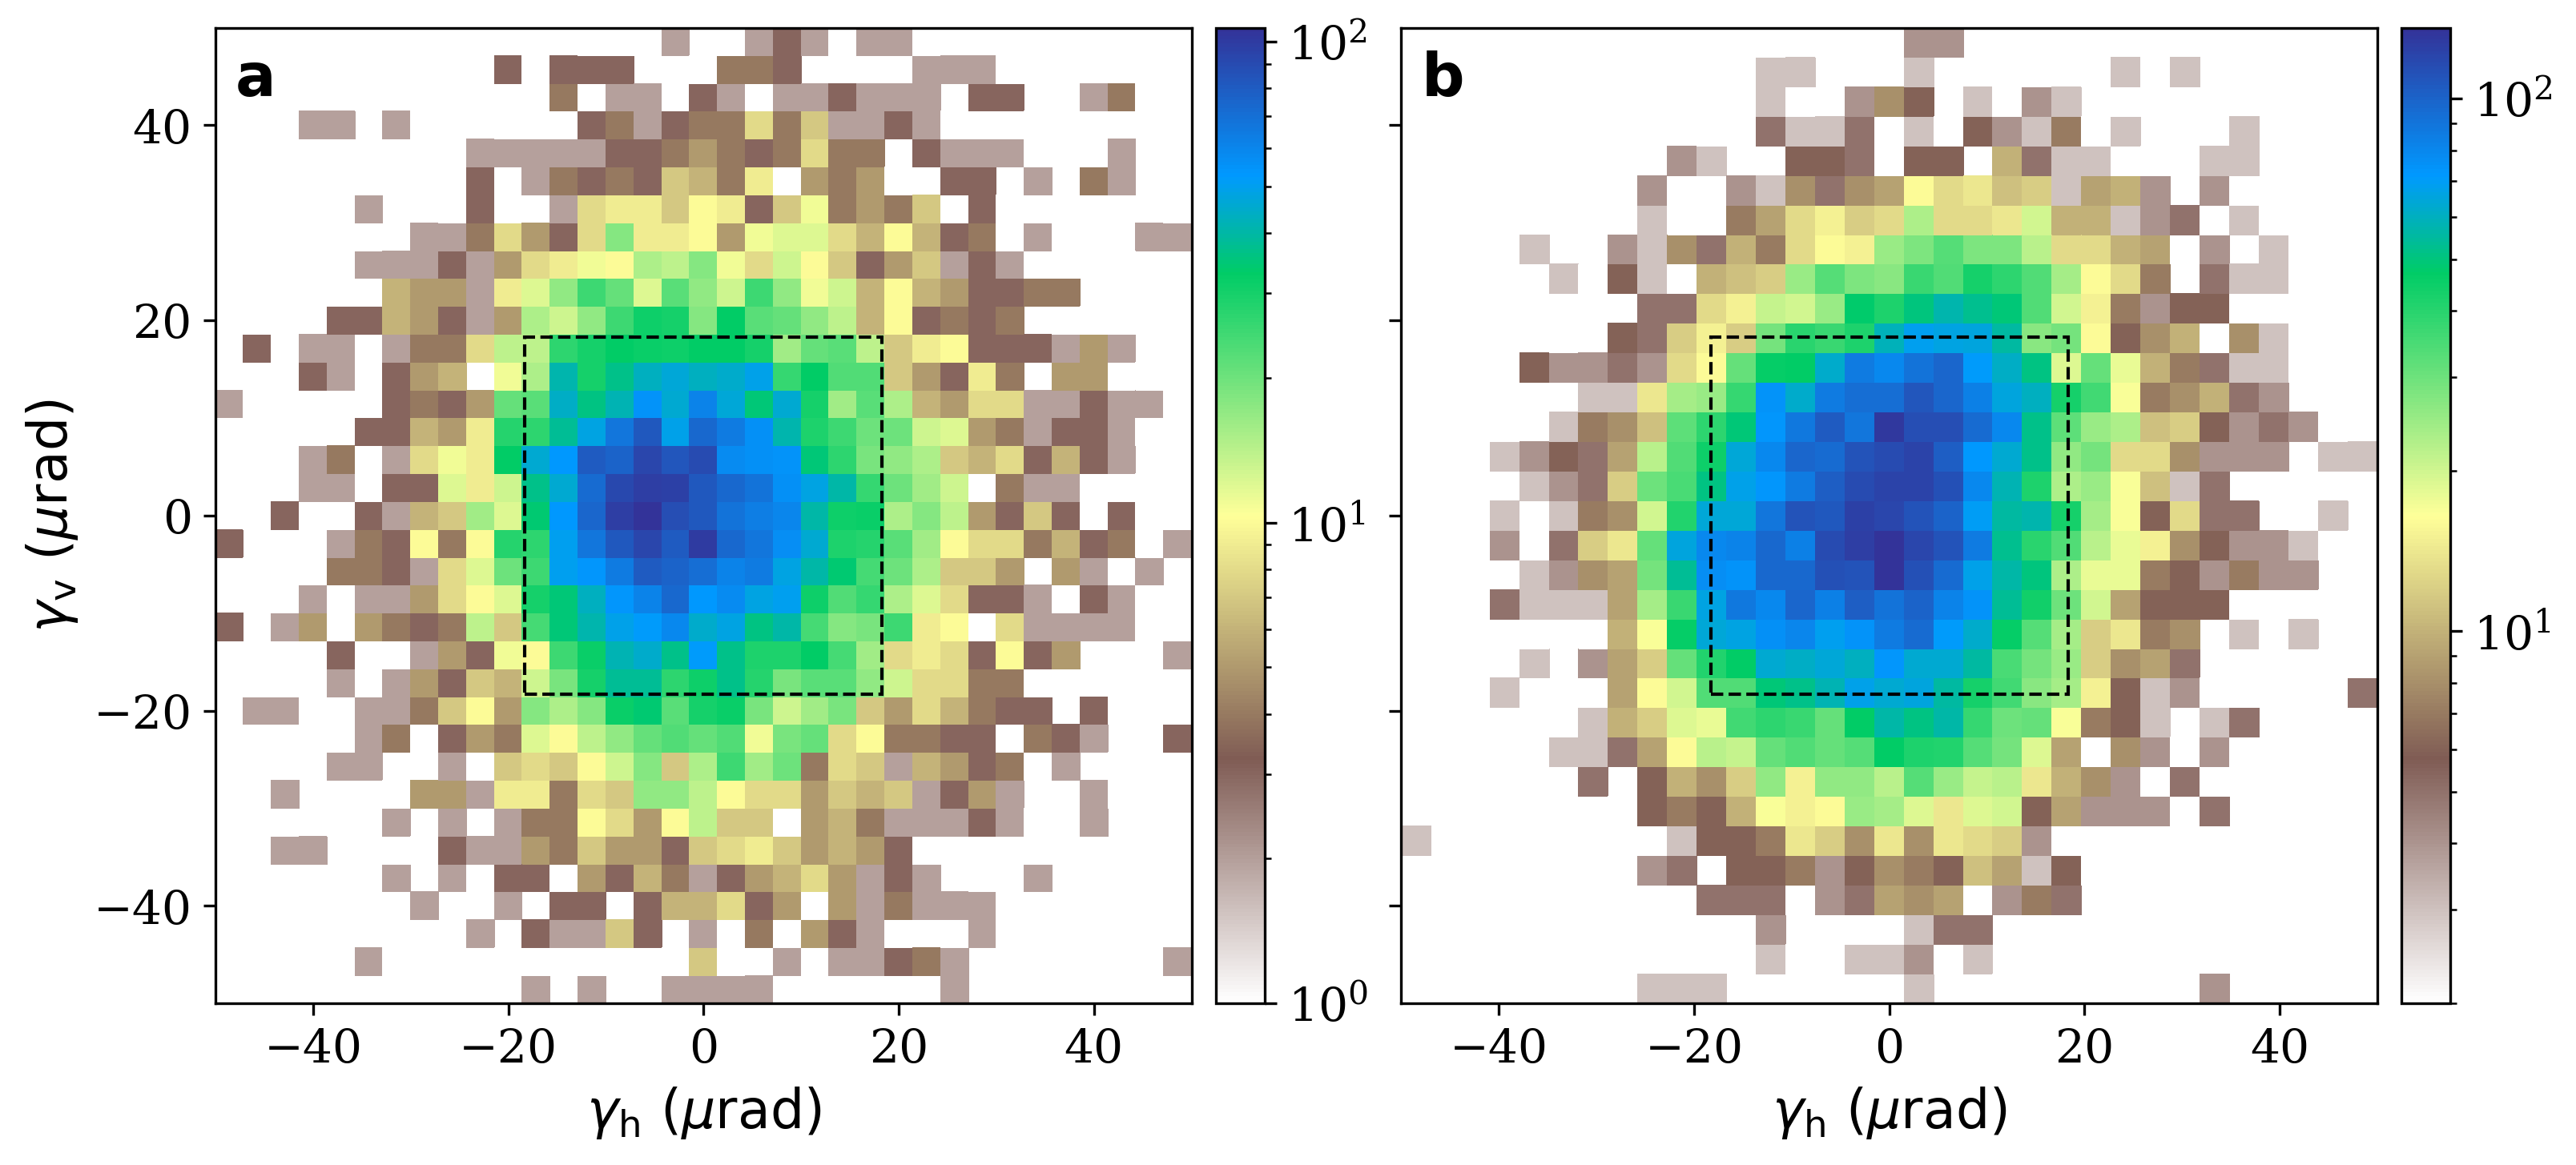

In [14]:
#fig = plt.figure(figsize=(6, 6))

fig = plt.figure(figsize=[12, 6], tight_layout=False, dpi=300)
gs = plt.GridSpec(1, 4)
gs.update(wspace=0.3)

a0 = plt.subplot(gs[0, :2])

px0 = 2*np.arctan2(.5*lx,L)*1e6
print('Central pixel {}'.format(px0))

# 3rd shift
k1, = np.where(fits.grp < 2)
x1 = np.arctan2((fits.P[k1,4]  - fits.P[k1,4].mean()) * lx, L) * 1e6 
y1 = np.arctan2((fits.P[k1,5]  - fits.P[k1,5].mean())* ly, L) * 1e6

print("")
print("3rd shift")
print("                x          y")
print("  Mean {:10.3f} {:10.3f}".format(np.mean(fits.P[k1,4]), np.mean(fits.P[k1,5])))
print("Median {:10.3f} {:10.3f}".format(np.median(fits.P[k1,4]), np.median(fits.P[k1,5])))
print("   IQR {:10.3f} {:10.3f}".format(iqr(fits.P[k1,4]),iqr(fits.P[k1,5])))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(fits.P[k1,4], 95)-np.percentile(fits.P[k1,4], 5),
                                       np.percentile(fits.P[k1,5], 95)-np.percentile(fits.P[k1,5], 5)))
print("Median {:10.3f} {:10.3f}".format(np.median(x1), np.median(y1)))
print("   IQR {:10.3f} {:10.3f}".format(iqr(x1),iqr(y1)))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(x1, 95)-np.percentile(x1, 5),
                                       np.percentile(y1, 95)-np.percentile(y1, 5)))

pxn = np.sum(np.logical_and(np.abs(y1)<px0, np.abs(x1)<px0))
print("CC: {} {} {}".format(px0, x1.size, float(pxn)/float(x1.size)))
rn = ((-1.5,1.5), (-1.5, 1.5))
rn = ((-50, 50), (-50, 50))
H, D, x_bins, y_bins = fits.get_center_distribution(2, 'count', i=k1, d=2.5, ranges=rn)
j = H<1
H[j] = float("nan")


im=fits.plot_center_distribution((x_bins, y_bins), H, ax=a0)
a0.add_patch(plt.Rectangle((-px0/2,-px0/2), px0, px0, fill=False, ls='--'))
a0.text(-48,43,'$\mathbf{a}$',fontsize=18)

# 4th shift
a0 = plt.subplot(gs[0, 2:])

k1, = np.where(fits.grp >= 2)
x1 = np.arctan2((fits.P[k1,4]  - fits.P[k1,4].mean()) * lx, L) * 1e6 
y1 = np.arctan2((fits.P[k1,5]  - fits.P[k1,5].mean())* ly, L) * 1e6

print("")
print("4th shift")
print("                x          y")
print("  Mean {:10.3f} {:10.3f}".format(np.mean(fits.P[k1,4]), np.mean(fits.P[k1,5])))
print("Median {:10.3f} {:10.3f}".format(np.median(fits.P[k1,4]), np.median(fits.P[k1,5])))
print("   IQR {:10.3f} {:10.3f}".format(iqr(fits.P[k1,4]),iqr(fits.P[k1,5])))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(fits.P[k1,4], 95)-np.percentile(fits.P[k1,4], 5),
                                       np.percentile(fits.P[k1,5], 95)-np.percentile(fits.P[k1,5], 5)))

print("Median {:10.3f} {:10.3f}".format(np.median(x1), np.median(y1)))
print("   IQR {:10.3f} {:10.3f}".format(iqr(x1),iqr(y1)))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(x1, 95)-np.percentile(x1, 5),
                                       np.percentile(y1, 95)-np.percentile(y1, 5)))
pxn = np.sum(np.logical_and(np.abs(y1)<px0, np.abs(x1)<px0))
print("CC: {} {} {}".format(px0, x1.size, float(pxn)/float(x1.size)))

rn = ((-1.5,1.5), (-1.5, 1.5))
rn = ((-50, 50), (-50, 50))
H, D, x_bins, y_bins = fits.get_center_distribution(2, 'count', i=k1, d=3, ranges=rn)
j = H<2
H[j] = float("nan")
im=fits.plot_center_distribution((x_bins, y_bins), H, ax=a0)
a0.tick_params(labelleft=False)
a0.set_ylabel('')
a0.add_patch(plt.Rectangle((-px0/2,-px0/2), px0, px0, fill=False, ls='--'))
a0.text(-48,43,'$\mathbf{b}$',fontsize=18)

plt.savefig("pdf/figure_4.pdf")
plt.savefig("eps/figure_4.eps")
plt.show()


Central pixel 36.59652332619913

3rd shift
                x          y
  Mean     -1.656      1.396
Median     -1.682      1.402
   IQR      0.497      0.557
   90%      1.378      1.613
Median     -0.976      0.246
   IQR     18.206     20.398
   90%     50.416     59.037
CC: 36.59652332619913 12257 0.9081341274373828

4th shift
                x          y
  Mean      3.770      1.466
Median      3.770      1.461
   IQR      0.502      0.596
   90%      1.281      1.497
Median      0.008     -0.161
   IQR     18.373     21.808
   90%     46.868     54.779
CC: 36.59652332619913 18049 0.9394980331320295


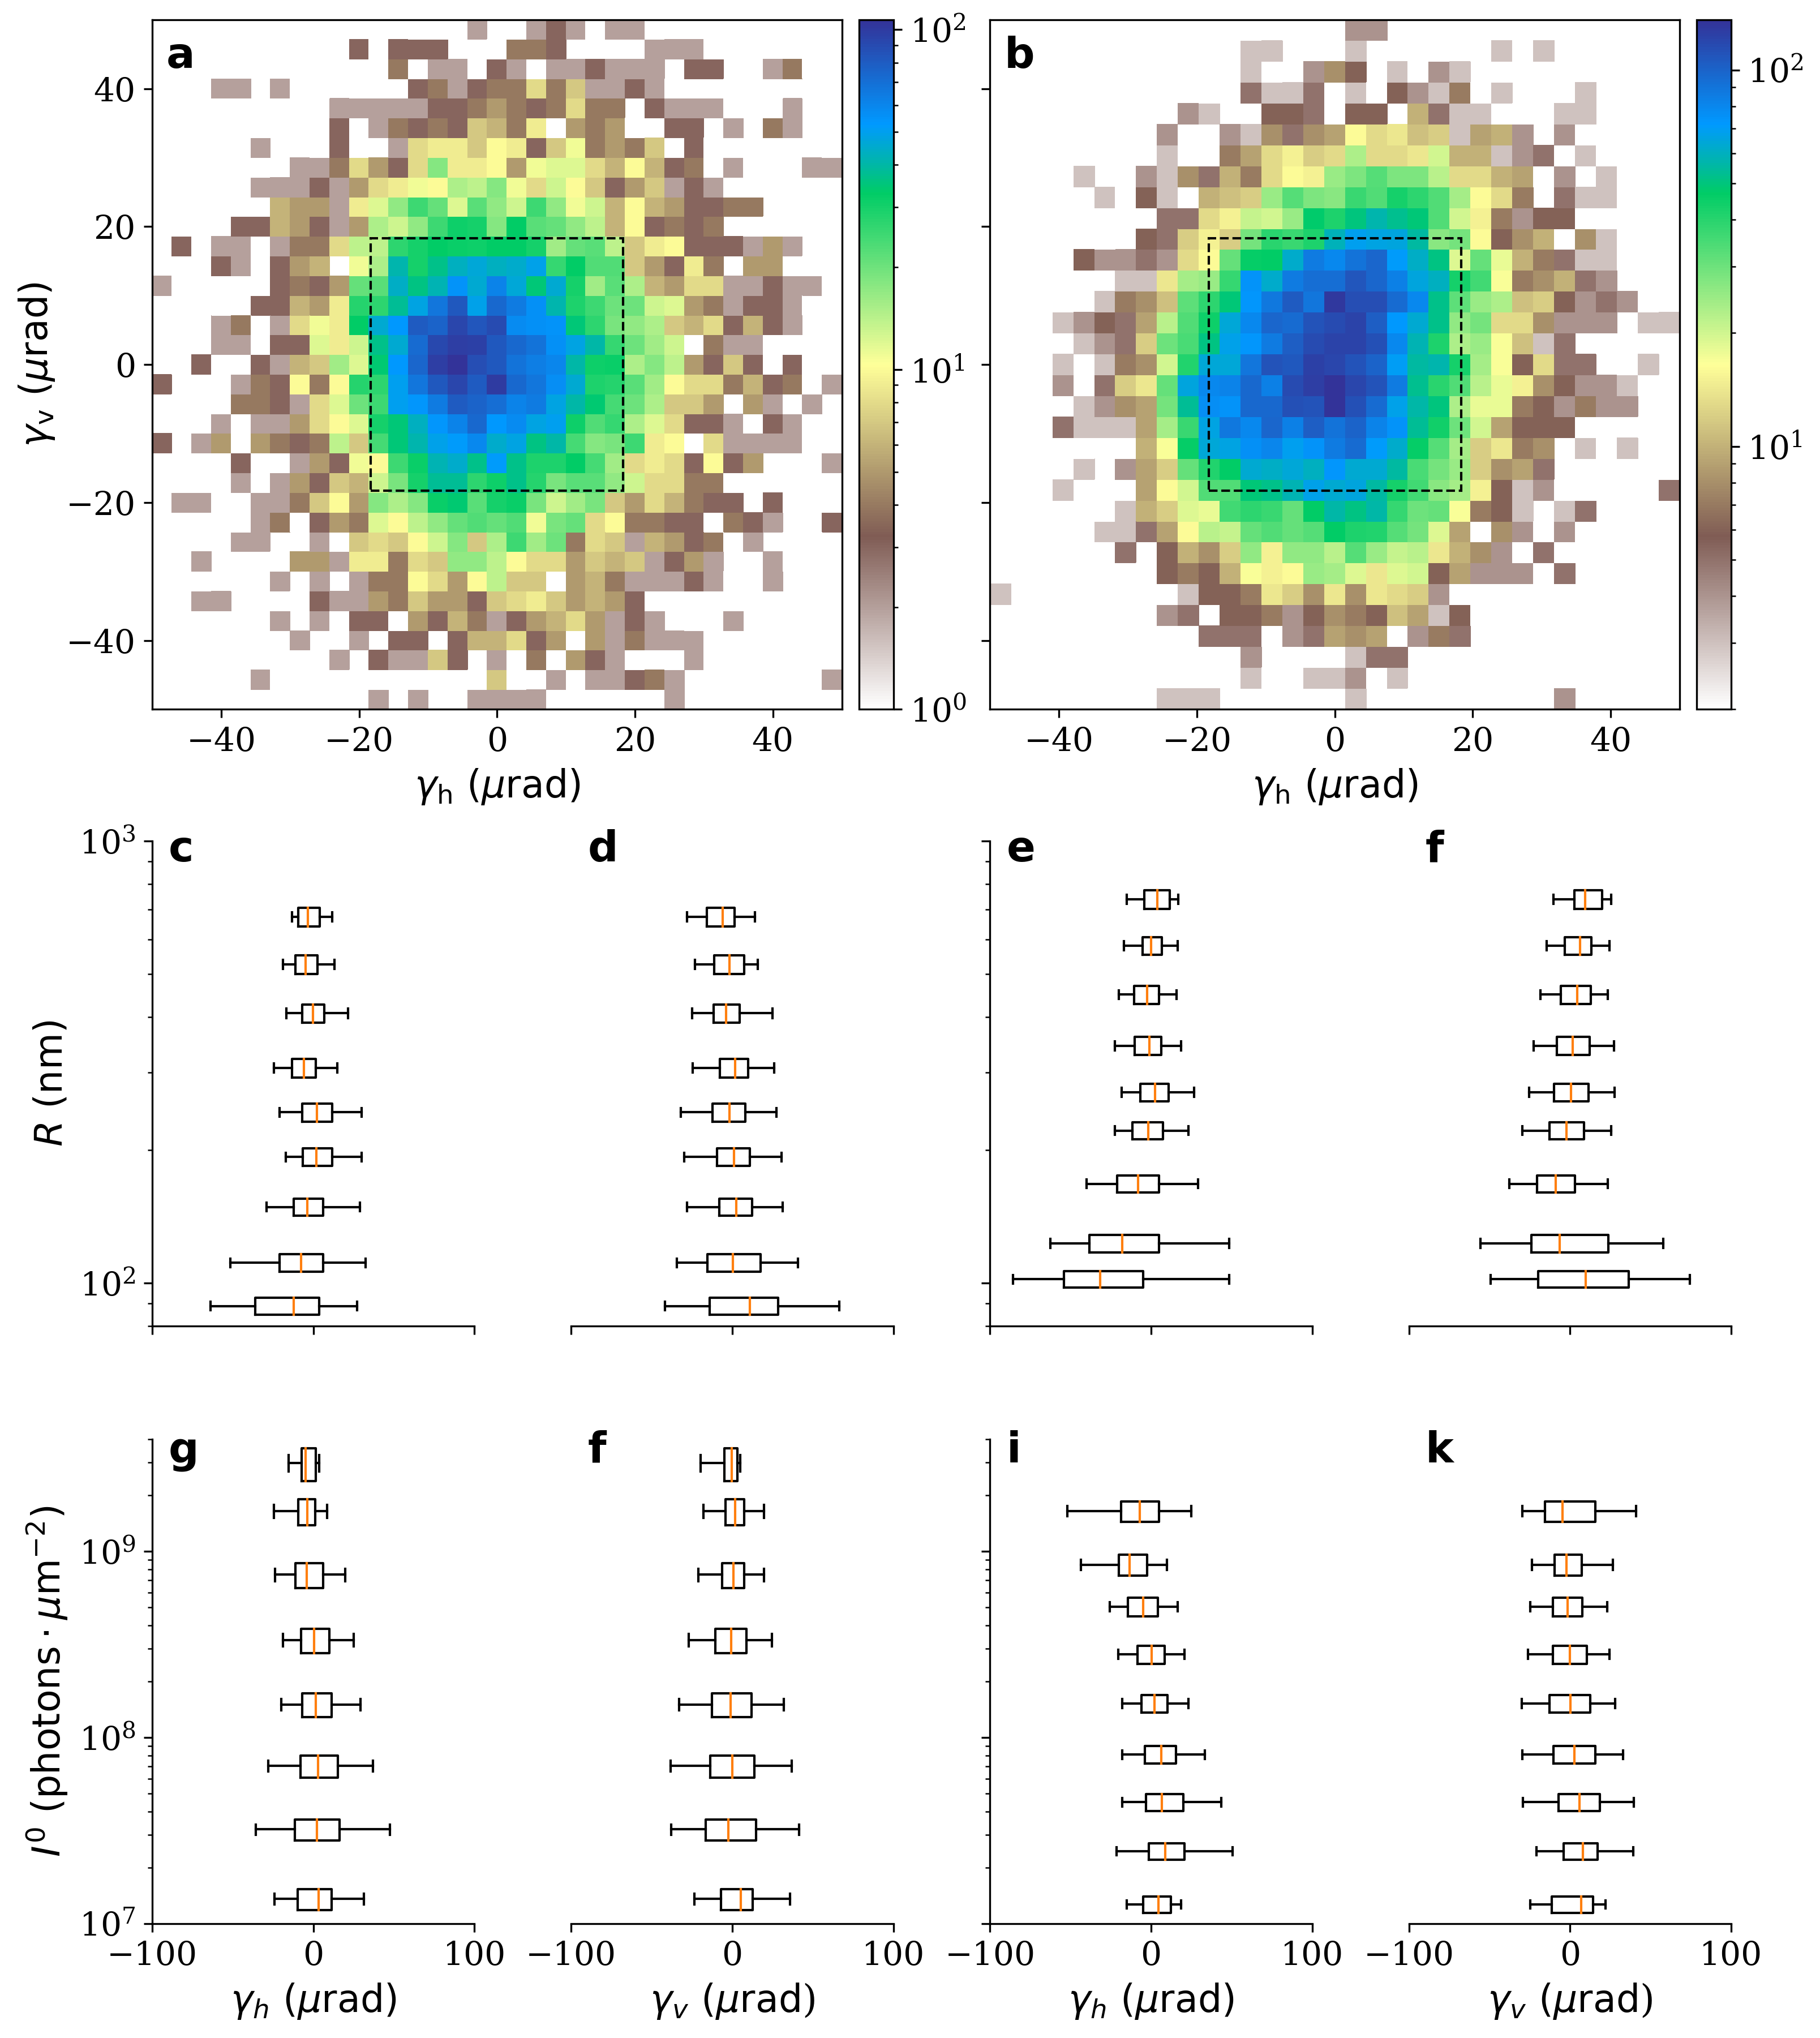

In [15]:
fig = plt.figure(figsize=[12, 15], tight_layout=False, dpi=300)
gs = plt.GridSpec(3, 4, height_ratios=[3, 2, 2])
gs.update(wspace=0.3)

a0 = plt.subplot(gs[0, :2])

px0 = 2*np.arctan2(.5*lx,L)*1e6
print('Central pixel {}'.format(px0))

# 3rd shift
k1, = np.where(fits.grp < 2)
x1 = np.arctan2((fits.P[k1,4]  - fits.P[k1,4].mean()) * lx, L) * 1e6 
y1 = np.arctan2((fits.P[k1,5]  - fits.P[k1,5].mean())* ly, L) * 1e6

print("")
print("3rd shift")
print("                x          y")
print("  Mean {:10.3f} {:10.3f}".format(np.mean(fits.P[k1,4]), np.mean(fits.P[k1,5])))
print("Median {:10.3f} {:10.3f}".format(np.median(fits.P[k1,4]), np.median(fits.P[k1,5])))
print("   IQR {:10.3f} {:10.3f}".format(iqr(fits.P[k1,4]),iqr(fits.P[k1,5])))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(fits.P[k1,4], 95)-np.percentile(fits.P[k1,4], 5),
                                       np.percentile(fits.P[k1,5], 95)-np.percentile(fits.P[k1,5], 5)))
print("Median {:10.3f} {:10.3f}".format(np.median(x1), np.median(y1)))
print("   IQR {:10.3f} {:10.3f}".format(iqr(x1),iqr(y1)))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(x1, 95)-np.percentile(x1, 5),
                                       np.percentile(y1, 95)-np.percentile(y1, 5)))

pxn = np.sum(np.logical_and(np.abs(y1)<px0, np.abs(x1)<px0))
print("CC: {} {} {}".format(px0, x1.size, float(pxn)/float(x1.size)))
rn = ((-1.5,1.5), (-1.5, 1.5))
rn = ((-50, 50), (-50, 50))
H, D, x_bins, y_bins = fits.get_center_distribution(2, 'count', i=k1, d=2.5, ranges=rn)
#x_bins = np.arctan2(x_bins*200e-6, 5.64) * 1e6
#y_bins = np.arctan2(y_bins*200e-6, 5.64) * 1e6
j = H<1
H[j] = float("nan")

#a0.ticklabel_format(style='sci', scilimits=(0, 0))

im=fits.plot_center_distribution((x_bins, y_bins), H, ax=a0)
a0.add_patch(plt.Rectangle((-px0/2,-px0/2), px0, px0, fill=False, ls='--'))
a0.text(-48,43,'$\mathbf{a}$',fontsize=18)

ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[2, 0]), plt.subplot(gs[2, 1])]
fits.plot_bandwidth_dist(ax, k1, (80,1000), (0.1e8,40e8), (-100, 100))

ax[0].text(-90,900,'$\mathbf{c}$',fontsize=18)
ax[1].text(-90,900,'$\mathbf{d}$',fontsize=18)
ax[2].text(-90,3e9,'$\mathbf{g}$',fontsize=18)
ax[3].text(-90,3e9,'$\mathbf{f}$',fontsize=18)


# 4th shift
a0 = plt.subplot(gs[0, 2:])

k1, = np.where(fits.grp >= 2)
x1 = np.arctan2((fits.P[k1,4]  - fits.P[k1,4].mean()) * lx, L) * 1e6 
y1 = np.arctan2((fits.P[k1,5]  - fits.P[k1,5].mean())* ly, L) * 1e6

print("")
print("4th shift")
print("                x          y")
print("  Mean {:10.3f} {:10.3f}".format(np.mean(fits.P[k1,4]), np.mean(fits.P[k1,5])))
print("Median {:10.3f} {:10.3f}".format(np.median(fits.P[k1,4]), np.median(fits.P[k1,5])))
print("   IQR {:10.3f} {:10.3f}".format(iqr(fits.P[k1,4]),iqr(fits.P[k1,5])))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(fits.P[k1,4], 95)-np.percentile(fits.P[k1,4], 5),
                                       np.percentile(fits.P[k1,5], 95)-np.percentile(fits.P[k1,5], 5)))

print("Median {:10.3f} {:10.3f}".format(np.median(x1), np.median(y1)))
print("   IQR {:10.3f} {:10.3f}".format(iqr(x1),iqr(y1)))
print("   90% {:10.3f} {:10.3f}".format(np.percentile(x1, 95)-np.percentile(x1, 5),
                                       np.percentile(y1, 95)-np.percentile(y1, 5)))
pxn = np.sum(np.logical_and(np.abs(y1)<px0, np.abs(x1)<px0))
print("CC: {} {} {}".format(px0, x1.size, float(pxn)/float(x1.size)))

rn = ((-1.5,1.5), (-1.5, 1.5))
rn = ((-50, 50), (-50, 50))
H, D, x_bins, y_bins = fits.get_center_distribution(2, 'count', i=k1, d=3, ranges=rn)
j = H<2
H[j] = float("nan")
im=fits.plot_center_distribution((x_bins, y_bins), H, ax=a0)
a0.tick_params(labelleft=False)
a0.set_ylabel('')
a0.add_patch(plt.Rectangle((-px0/2,-px0/2), px0, px0, fill=False, ls='--'))
a0.text(-48,43,'$\mathbf{b}$',fontsize=18)

ax = [plt.subplot(gs[1, 2]), plt.subplot(gs[1, 3]), plt.subplot(gs[2, 2]), plt.subplot(gs[2, 3])]
fits.plot_bandwidth_dist(ax, k1, (80,1000), (0.1e8,40e8), (-100, 100), labelleft=False)

ax[0].text(-90,900,'$\mathbf{e}$',fontsize=18)
ax[1].text(-90,900,'$\mathbf{f}$',fontsize=18)
ax[2].text(-90,3e9,'$\mathbf{i}$',fontsize=18)
ax[3].text(-90,3e9,'$\mathbf{k}$',fontsize=18)


plt.show()


1000.0


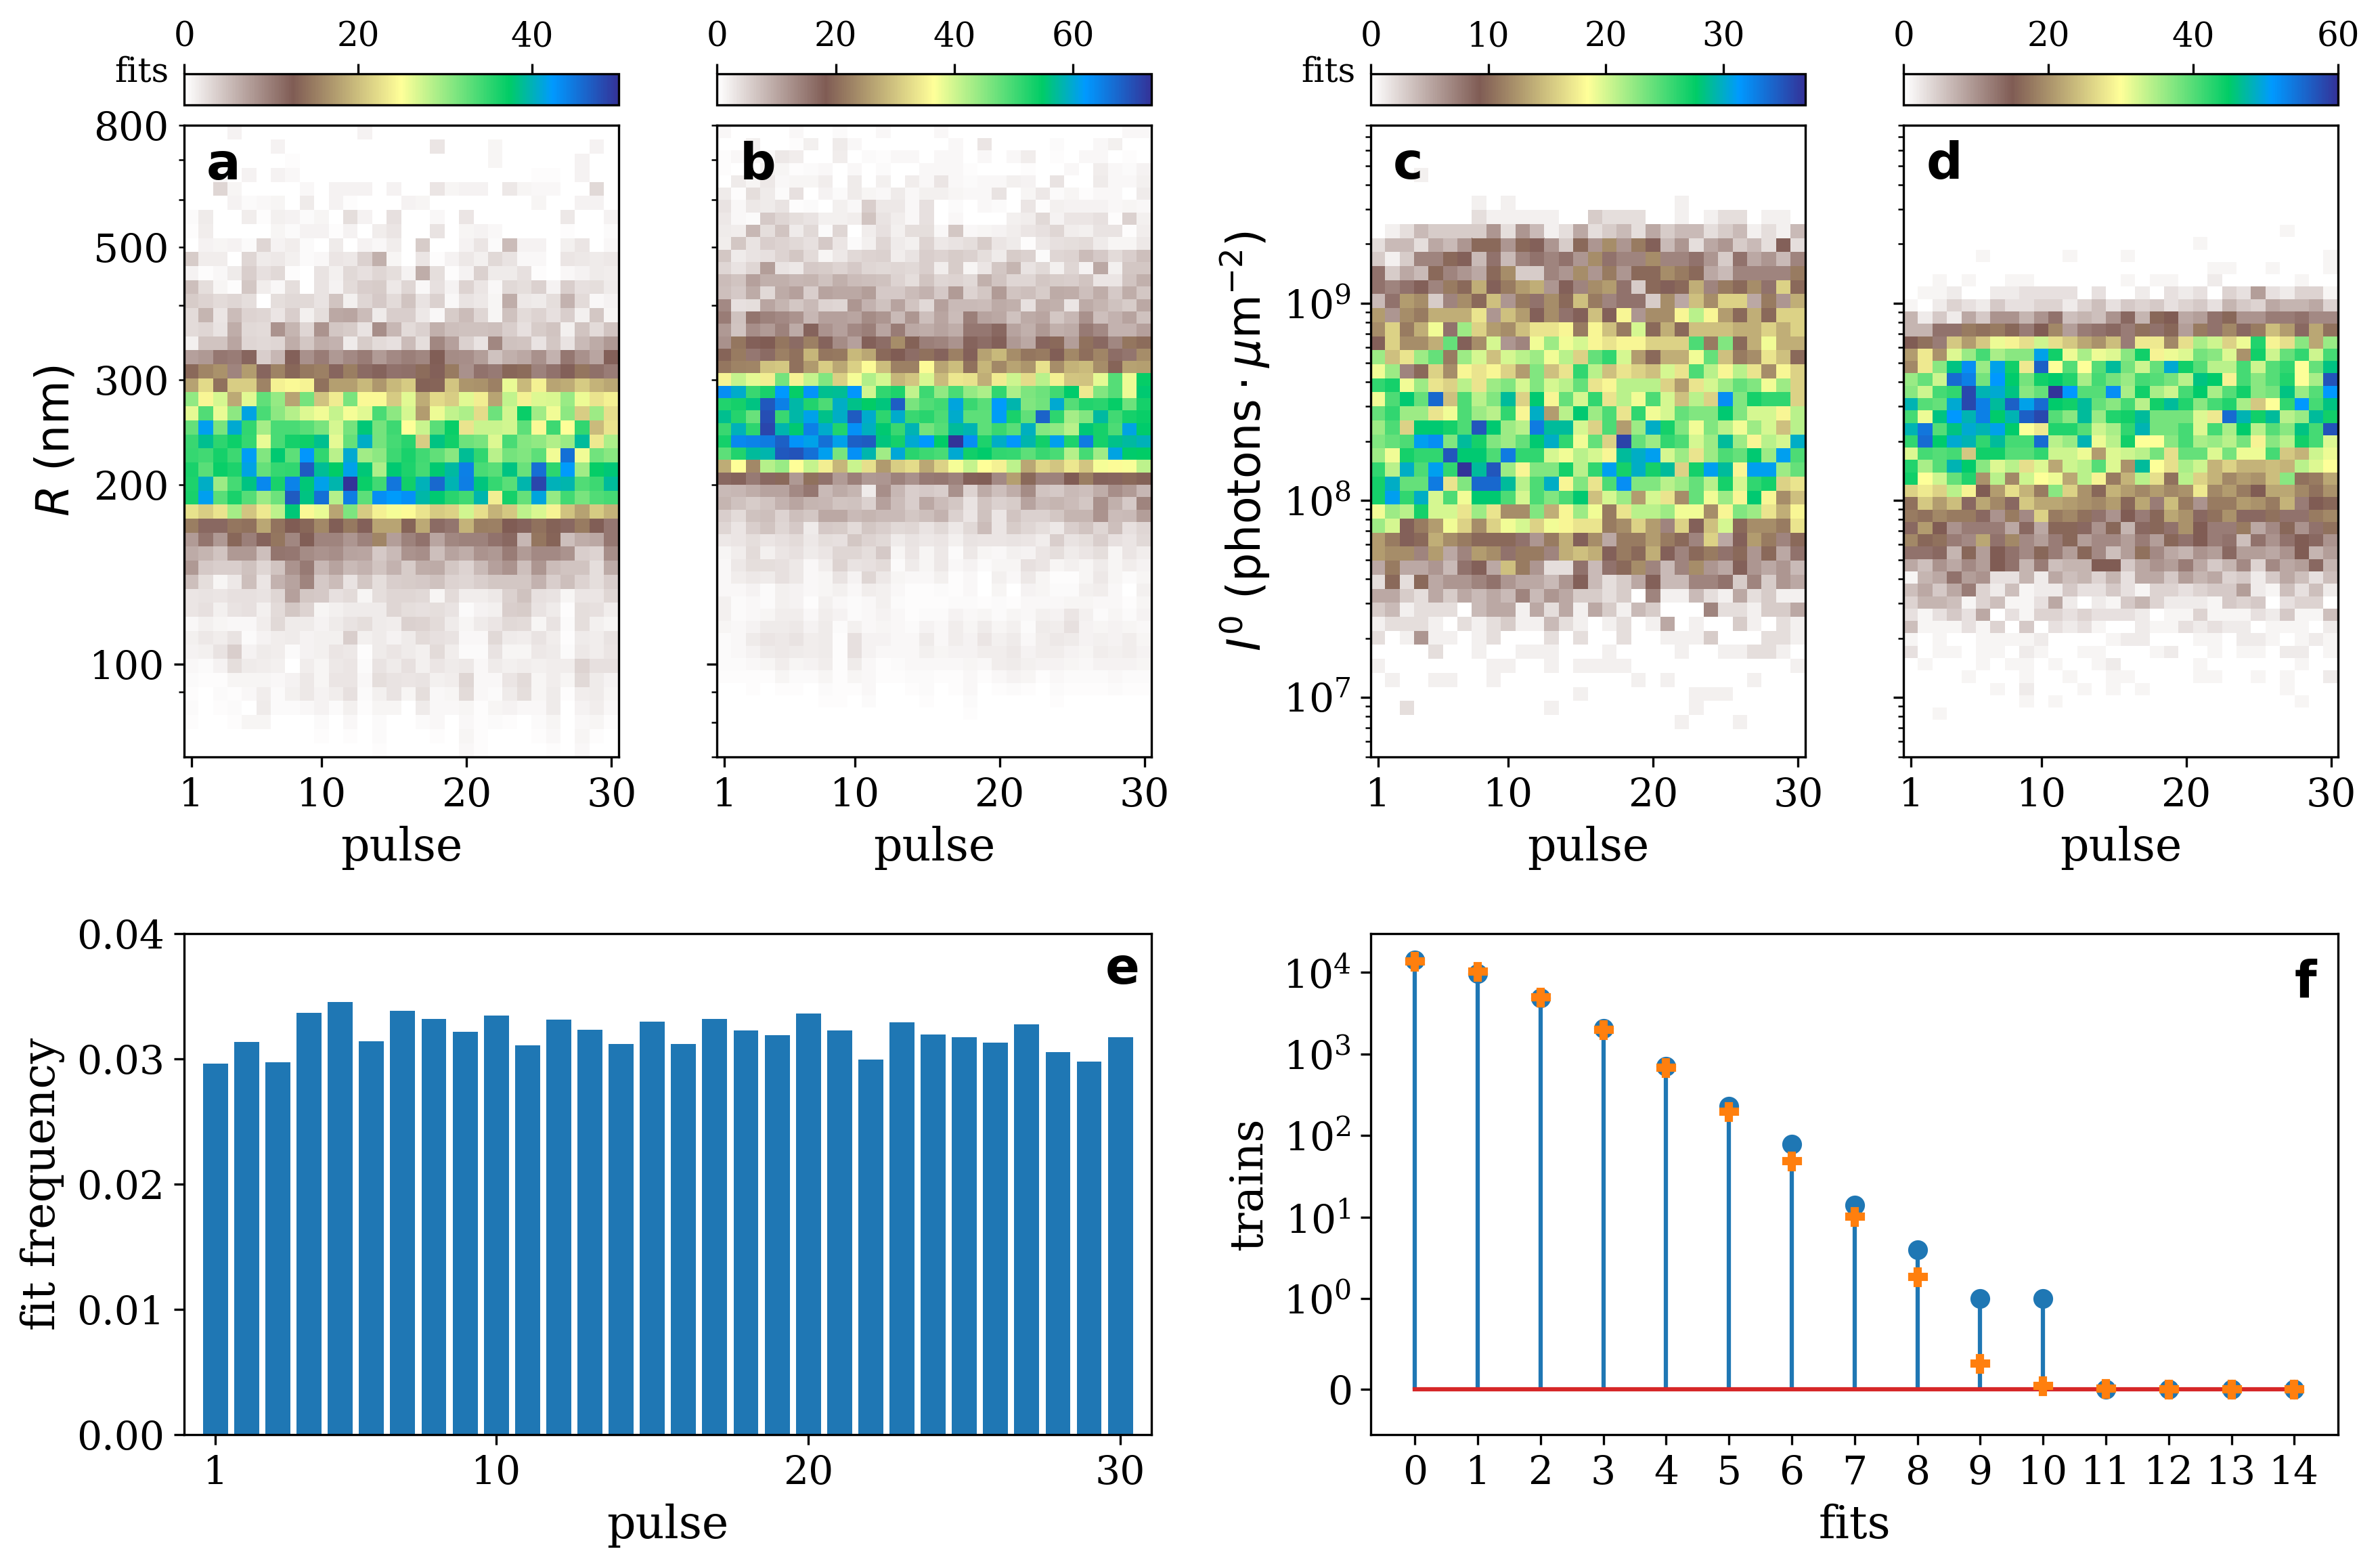

In [16]:
plt.rc('text', usetex=True)
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('axes', titlesize=16)

# histograms of size and incident photon intensity by pulses in a train
fig = plt.figure(figsize=[12, 8], tight_layout=True, dpi=300)
gs = plt.GridSpec(2, 2, height_ratios=[3,2.2])
gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1])

# shifts: 3rd, 4th
k = [np.where(fits.grp < 2)[0], np.where(fits.grp >= 2)[0], ]

# size
ax = [ plt.subplot(gs0[0, 0]), plt.subplot(gs0[0, 1]) ]
ims=fits.plot_pulse_hist(ax, 3, k, (70, 800))


for i in range(1):
    ax[i].set_yticks([100])
    ax[i].set_yticks([90] + list(range(200, 900, 100)), minor=True)
    ax[i].set_yticklabels(['100'])
    ax[i].set_yticklabels(['', '200', '300', '','500', '', '', '800'], minor=True)

ax[0].set_ylabel('$R\ (\mathrm{nm})$')
ax[0].text(2, 650, '$\mathbf{a}$', fontsize=18)
ax[1].text(2, 650, '$\mathbf{b}$', fontsize=18)

# incident photon intensity
ax = [ plt.subplot(gs1[0, 0]), plt.subplot(gs1[0, 1]) ]
ims2 = fits.plot_pulse_hist(ax, 2, k, (.5e7, 80e8))
ax[0].set_ylabel('$I^0\ (\mathrm{photons}\cdot\mu\mathrm{m}^{-2})$')

ax[0].text(2, 4.3e9, '$\mathbf{c}$', fontsize=18)
ax[1].text(2, 4.3e9, '$\mathbf{d}$', fontsize=18)


# distribution of fit conuts in a train
mu, n, p = fits.get_ntrains_by_nfit()
grps = np.array(fits.grps)

# 3rd shift
k = grps < 20

ax = plt.subplot(gs[1, 0])

k, = np.where(fits.run < len(fits.runs)-3)

ax.bar(np.arange(1,31),np.bincount(fits.cell[k]) / float(fits.cell.size))
ax.set_xticks([1,10,20,30])
ax.set_xlim([0,31])
ax.set_xlabel('pulse')
ax.set_ylabel('fit frequency')

ax.set_ylim(0, 0.04)

ax.text(29.5, 0.036, '$\mathbf{e}$', fontsize=18)

# 4th shift
k = grps >= 0

ax = plt.subplot(gs[1, 1])
fits.plot_ntrains_by_nfit(mu[k], n[k,:], p[k,:], ax=ax)
ax.set_ylim(-0.5, 3e4)
ax.set_xlabel("fits")
ax.set_ylabel("trains")
ax.text(14, 5e3, '$\mathbf{f}$', fontsize=18)

print(n.sum()/32)

fig.savefig("pdf/figure_8.pdf")
fig.savefig("eps/figure_8.eps")
plt.show()



In [17]:
from __future__ import print_function
# correlation of the parameters (R, I, x, y) reconstructed from diffraction in two successive pulses
print(" "*9+'\tI0\tR\tx\ty')
k = fits.get_consiquent_fits()

ki = k[fits.grp[k] < 2]
C = fits.corrcoef(fits.P[ki,:].T, fits.P[ki+1,:].T)
D = np.diag(C)
print("3rd shift", end='')
for j in range(4):
    print("\t{:.2g}".format(D[j+1]), end='')
print()

ki = k[fits.grp[k] >= 2]
C = fits.corrcoef(fits.P[ki,:].T, fits.P[ki+1,:].T)
D = np.diag(C)
print("4th shift", end='')
for j in range(4):
    print("\t{:.2g}".format(D[j+1]), end='')
print()


         	I0	R	x	y
3rd shift	0.18	0.0077	0.047	0.011
4th shift	0.022	0.00077	0.12	-0.004
